### AlexNet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
from dataset import mnist
from util import (
    get_torch_size_string,
    print_model_parameters,
    print_model_layers,
    model_train,
    model_eval,
    model_test
)
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Hyperparameters

In [2]:
device      = 'cpu' # cpu / mps
n_epoch     = 1
batch_size  = 128
print_every = 1
print ("Ready.")

Ready.


### Dataset

In [3]:
train_iter,test_iter,train_data,train_label,test_data,test_label = \
    mnist(root_path='../data',batch_size=128)
print ("MNIST ready.")

MNIST ready.


### Define AlexNet

In [4]:
class AlexNetClass(nn.Module):
    def __init__(
        self,
        name        = 'alexnet',
        x_dim       = (1,28,28),
        num_classes = 1000
    ):
        super(AlexNetClass,self).__init__()
        self.name        = name
        self.x_dim       = x_dim
        self.num_classes = num_classes
        
        self.net = nn.Sequential(
            # nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1), # comment to handle 28x28 inputs
            # nn.ReLU(), 
            # nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.Flatten(),
            nn.LazyLinear(4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.LazyLinear(4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes)
        )
        
        self.layer_names = []
        for l_idx,layer in enumerate(self.net):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.layer_names.append(layer_name)
    
    def init_param(self,VERBOSE=False):
        """
            Initialize parameters
        """
        for m_idx,m in enumerate(self.modules()):
            if VERBOSE:
                print ("[%02d]"%(m_idx))
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.LazyConv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm1d) or isinstance(m,nn.BatchNorm2d): 
                nn.init.constant_(m.weight,1.0)
                nn.init.constant_(m.bias,0.0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.LazyLinear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
                
    def forward(self,x):
        """
            Forward propagate
        """
        intermediate_output_list = []
        for layer in self.net:
            x = layer(x)
            intermediate_output_list.append(x)
        final_output = x
        return final_output,intermediate_output_list
    
print ("Ready.")

Ready.


In [5]:
alexnet = AlexNetClass(
    name        = 'alexnet',
    x_dim       = (1,28,28),
    num_classes = 10
).to(device)
loss = nn.CrossEntropyLoss()
optm = th.optim.Adam(alexnet.parameters(),lr=1e-3)
print ("Ready.")

Ready.


/Users/sj/anaconda3/envs/mujoco/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Print model layers

In [6]:
x_torch = th.randn((16,)+alexnet.x_dim).to(device)
print_model_layers(alexnet,x_torch)

batch_size:[16]
[  ] layer:[          input] size:[    16x1x28x28]
[ 0] layer:[  lazyconv2d_00] size:[  16x256x28x28] numel:[   3211264]
[ 1] layer:[        relu_01] size:[  16x256x28x28] numel:[   3211264]
[ 2] layer:[   maxpool2d_02] size:[  16x256x13x13] numel:[    692224]
[ 3] layer:[  lazyconv2d_03] size:[  16x384x13x13] numel:[   1038336]
[ 4] layer:[        relu_04] size:[  16x384x13x13] numel:[   1038336]
[ 5] layer:[  lazyconv2d_05] size:[  16x384x13x13] numel:[   1038336]
[ 6] layer:[        relu_06] size:[  16x384x13x13] numel:[   1038336]
[ 7] layer:[  lazyconv2d_07] size:[  16x256x13x13] numel:[    692224]
[ 8] layer:[        relu_08] size:[  16x256x13x13] numel:[    692224]
[ 9] layer:[   maxpool2d_09] size:[    16x256x6x6] numel:[    147456]
[10] layer:[     flatten_10] size:[       16x9216] numel:[    147456]
[11] layer:[  lazylinear_11] size:[       16x4096] numel:[     65536]
[12] layer:[        relu_12] size:[       16x4096] numel:[     65536]
[13] layer:[     dropou

### Print model parameters

In [7]:
print_model_parameters(alexnet)

[ 0] parameter:[               net.0.weight] shape:[   256x1x5x5] numel:[      6400]
[ 1] parameter:[                 net.0.bias] shape:[         256] numel:[       256]
[ 2] parameter:[               net.3.weight] shape:[ 384x256x3x3] numel:[    884736]
[ 3] parameter:[                 net.3.bias] shape:[         384] numel:[       384]
[ 4] parameter:[               net.5.weight] shape:[ 384x384x3x3] numel:[   1327104]
[ 5] parameter:[                 net.5.bias] shape:[         384] numel:[       384]
[ 6] parameter:[               net.7.weight] shape:[ 256x384x3x3] numel:[    884736]
[ 7] parameter:[                 net.7.bias] shape:[         256] numel:[       256]
[ 8] parameter:[              net.11.weight] shape:[   4096x9216] numel:[  37748736]
[ 9] parameter:[                net.11.bias] shape:[        4096] numel:[      4096]
[10] parameter:[              net.14.weight] shape:[   4096x4096] numel:[  16777216]
[11] parameter:[                net.14.bias] shape:[        4096]

### Train AlexNet

In [8]:
model_train(alexnet,optm,loss,train_iter,test_iter,n_epoch,print_every,device)

epoch:[ 0/1] loss:[0.355] train_accr:[0.9819] test_accr:[0.9800].


### Test AlexNet

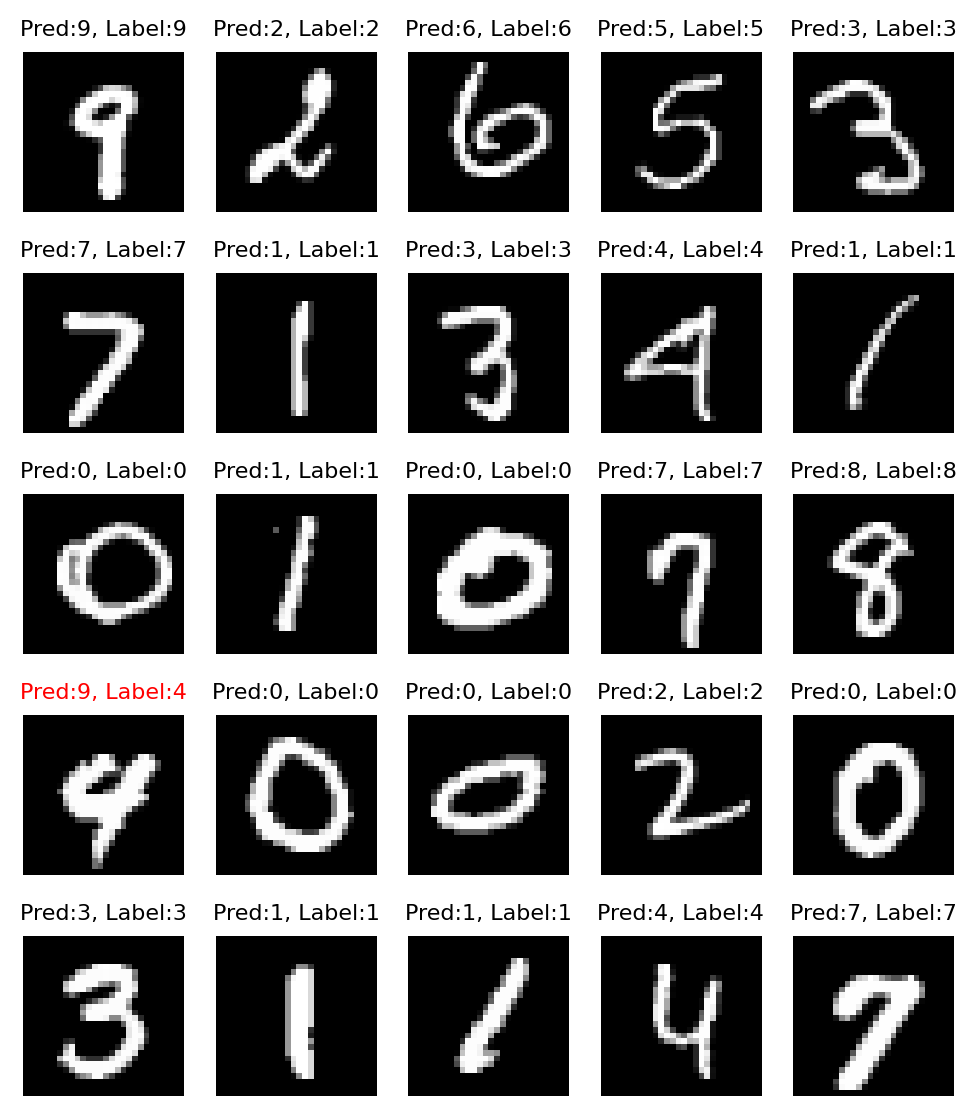

In [9]:
model_test(alexnet,test_data,test_label,device)